# Resnet Classifier

1-shot classifier

In [1]:
%matplotlib inline

# system libraries
import os
from glob import glob
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# numerical,image and plotting stuff
import math
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io
import skimage.transform as tf
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
# get all image file names and associated class from their latest location
files = glob('images/train/*/*.jpg')
files.sort()
df = pd.DataFrame({'fpath':files})
df['category'] = df.fpath.str.extract('images/train/Type_([0-9]*)/', expand=False).astype(np.int8) # extract class
print(df.groupby('category').count())
df.head()

          fpath
category       
1           249
2           781
3           450


,fpath,category
0,images/train/Type_1/0.jpg,1
1,images/train/Type_1/10.jpg,1
2,images/train/Type_1/1013.jpg,1
3,images/train/Type_1/1014.jpg,1
4,images/train/Type_1/1019.jpg,1


We perform some basic augmentation of our images with the following functions

In [3]:
# read and randomly crop a portion of the image
def read_resize(fpath,rng,h=224,w=224,ch=3):
    im = Image.open(fpath)
    w_im, h_im = im.size
    crop_offset = rng.uniform(low=-20,high=20,size=1)[0]
    if w_im < h_im: # general case
        mid_h = h_im/2
        half_w = w_im/2
        bbox = (0,mid_h-half_w+crop_offset,w_im,mid_h+half_w+crop_offset)
    else:
        logging.debug(fpath + ' is wide not long')
        mid_w = w_im/2
        half_h = h_im/2
        bbox = (mid_w-half_h+crop_offset,0,mid_w+half_h+crop_offset,h_im)
    im_sml = im.crop(bbox).resize((w,h))

    return np.asarray(im_sml)

# augment image as 3D ndarray
def augment(img,rng,h=224,w=224):
    r_rotate = rng.uniform(-np.pi/6,np.pi/6,1)[0]
    tf_rotate = tf.SimilarityTransform(rotation=r_rotate)
    tf_scale = tf.SimilarityTransform(scale=rng.uniform(1,1.5,1))
    tf_shear = tf.AffineTransform(shear=rng.uniform(-0.1,0.1,1))
    tf_shift = tf.SimilarityTransform(translation=[-w/2, -h/2])
    tf_shift_inv = tf.SimilarityTransform(translation=[w/2, h/2])
    trans = tf_shift + tf_scale + tf_shear + tf_rotate + tf_shift_inv

    img_aug = tf.warp(img, trans.inverse)
    # randomly flip vertically
    if rng.uniform() > 0.5:
        img_aug = img_aug[::-1,:,:]
    # randomly flip horizontally
    if rng.uniform() > 0.5:
        img_aug = img_aug[:,::-1,:]

    return img_aug

# scale to [0,1]
def scale_pixels(im):
    return im/255.


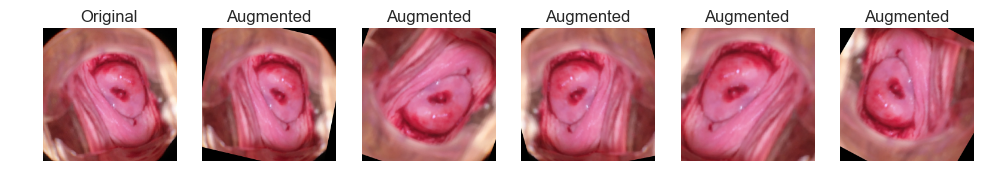

In [4]:
# sample some augmented pictures

fpath = df.fpath.iloc[0]
rng = np.random.RandomState(1)
im = read_resize(fpath,rng)

plt.figure(figsize=(12,3))
plt.subplot(161)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
for i in range(2,7):
    plt.subplot(1,6,i)
    plt.imshow(augment(im,rng)) # sample augment
    plt.title('Augmented')
    plt.axis('off')

Next, we write a generator that will take in a dataframe of files with labels and generate a stratified sample each batch.

In [5]:
def gen(df,rng,batch_size=64,h_out=224,w_out=224,ch_out=3):
    """
    This generator produces a batch of (X,y).
    Images are randomly augmented.
    
    Inputs:
    df is a pandas dataframe containing the file path (fpath) and class (category)

    Outputs:
    X is a 4D tensor of shape (batch_size,h,w,ch)
    y is a 2D vector of (batch_size,3), for the 3 classes
    """

    n = len(df)
    total_batch = int(np.ceil(n / batch_size))
    logging.info('generating %d batches with %d samples per epoch' % (total_batch,n))

    # initialize labelBinarizer
    ohc = LabelBinarizer()
    ohc.fit(df.category)

    while True:
        # shuffle examples every epoch
        df_shuffled = df.iloc[rng.permutation(n)]
        for i_batch in range(total_batch):
            # limit end index by size of df_gen to prevent
            # indexing up to the next multiple of batch_size
            i_start, i_end = i_batch * batch_size, min((i_batch + 1) * batch_size,n)
            i_batch_size = i_end - i_start
            X = np.zeros((i_batch_size,h_out,w_out,ch_out))
            Y = np.zeros((i_batch_size,3))
            for i in range(i_start,i_end):
                fpath = df_shuffled.iloc[i]['fpath']
                im = read_resize(fpath,rng)
                im_aug = augment(im,rng,h=h_out,w=w_out)
                i_intrabatch = i - i_start
                X[i_intrabatch,...] = im_aug
            Y = ohc.transform(df_shuffled.iloc[i_start:i_end]['category'])
            logging.debug('yielding batch %d of size %d' % (i_batch, i_batch_size))
            yield(X,Y)

In [6]:
# define model
from keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Layer,\
    Activation, Dropout, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, \
    Dense, add, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

# setup model

# creates a residual block
def res_block(input_layer,depth,layer_number,if_pool=True):
    # skip bn-relu for first layer (0-indexed here)
    if layer_number > 0:
        bn = BatchNormalization()(input_layer)
        bn_relu = Activation('relu')(bn)
    else:
        bn_relu = input_layer
    bn_relu_conv = Conv2D(depth,(3,3),name='conv'+str(layer_number)+'_1',
                               padding='same',kernel_regularizer=l2(0.0001))(bn_relu)
    bn_relu_conv_bn = BatchNormalization()(bn_relu_conv)
    bn_relu_conv_bn_relu = Activation('relu')(bn_relu_conv_bn)
    bn_relu_conv_bn_relu_conv = Conv2D(depth,(3,3),name='conv'+str(layer_number)+'_2',
                               padding='same',kernel_regularizer=l2(0.0001))(bn_relu_conv_bn_relu)
    residual = Conv2D(depth,(1,1),name='resid'+str(layer_number),padding='same',
                             kernel_regularizer=l2(0.0001))(input_layer)
    merged = add([bn_relu_conv_bn_relu_conv,residual])
    merged_pool = MaxPooling2D((2,2),strides=(2,2))(merged)
    return merged_pool


def new_model(h_in=224, w_in=224 ,ch=3):
    
    image_input = Input(shape=(224,224,3))

    res1_out = res_block(image_input,16,0,True)
    res2_out = res_block(res1_out,32,1,True)
    res3_out = res_block(res2_out,64,2,True)
    res4_out = res_block(res3_out,128,3,True)
    res5_out = res_block(res4_out,128,4,False)
    res6_out = res_block(res5_out,256,5,True)
    res7_out = res_block(res6_out,512,6,False)
    res7_avg = GlobalAveragePooling2D()(res7_out)
    res7_max = GlobalMaxPooling2D()(res7_out)
    post_conv_flat = concatenate([res7_avg,res7_max])

    post_conv_flat = Dropout(0.2)(post_conv_flat)
    post_conv_flat = Dense(128, activation='relu')(post_conv_flat)
    post_conv_flat = Dropout(0.2)(post_conv_flat)
    predictions = Dense(3, activation='softmax')(post_conv_flat)

    model = Model(inputs=[image_input],outputs=[predictions])
    return model

model = new_model()
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


# setup tensorboard graph directory
graph_dir = 'graph/graph_resnet'
if not os.path.exists(graph_dir):
    os.makedirs(graph_dir)

# prepare callbacks
tb = TensorBoard(log_dir=graph_dir, write_graph=True, write_images=True)
mc_coord = ModelCheckpoint(filepath='models/classifier_ep{epoch:02d}_loss{val_loss:.2f}_acc{val_acc:.2f}.h5',
                           verbose=1,save_best_only=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, 
                             verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=1e-7)


Using TensorFlow backend.


In [7]:
# initialize generators
rng = np.random.RandomState(290615)

# setup epoch params
n, batch_size = len(df), 64
total_batch = int(np.ceil(n / batch_size))

# we just use train valid test for training our model
ix_coord = rng.choice(range(3),p=[0.8,0.1,0.1],size=len(df))
df_train = df.ix[ix_coord==0]
df_valid = df.ix[ix_coord==1]
df_test = df.ix[ix_coord==2]
gn_train = gen(df_train,rng=rng,batch_size=batch_size,h_out=224,w_out=224)
gn_valid = gen(df_valid,rng=rng,batch_size=batch_size,h_out=224,w_out=224)
steps_per_epoch = int(np.ceil(len(df_train) / batch_size))
validation_steps = int(np.ceil(len(df_valid) / batch_size))

In [ ]:
logger.setLevel(logging.INFO)
model.fit_generator(generator=gn_train,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=gn_valid,
                    validation_steps=validation_steps,
                    epochs=500,
                    callbacks=[tb,mc_coord,reducelr])